In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2024-06-19 15:44:30.898356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 15:44:30.898620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 15:44:31.089403: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Define paths for train and test data

In [2]:
train_path = '/kaggle/input/cassava-leaf-disease-classification/train'
test_path = '/kaggle/input/cassava-leaf-disease-classification/test'

# Gather file paths for train data

In [3]:
train_files = []
for dirname, _, filenames in os.walk(train_path):
    for filename in filenames:
        train_files.append(os.path.join(dirname, filename))

# Gather file paths for test data

In [4]:
test_files = []
for dirname, _, filenames in os.walk(test_path):
    for filename in filenames:
        test_files.append(os.path.join(dirname, filename))

# Create DataFrames for train and test data

In [5]:
train_df = pd.DataFrame({'filename': train_files})
test_df = pd.DataFrame({'filename': test_files})

# Extract labels from file paths

In [6]:
train_df['label'] = train_df['filename'].str.split('/').str[-2]

# Define class labels

In [7]:
classes = ["Cassava Bacterial Blight (CBB)", "Cassava Brown Streak Disease (CBSD)",
           "Cassava Green Mottle (CGM)", "Cassava Mosaic Disease (CMD)", "Healthy"]

# Load pre-trained models

In [8]:
def load_pretrained_model(model_name, input_shape=(224, 224, 3)):
    if model_name == 'EfficientNetB0':
        base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=input_shape)
    elif model_name == 'ResNet50':
        base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=input_shape)
    elif model_name == 'MobileNetV2':
        base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=input_shape)
    return base_model

# Preprocess image function

In [9]:
def preprocess_image(filename, target_size=(224, 224)):
    img = load_img(filename, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Extract features in batches

In [10]:
def extract_features_in_batches(model, filenames, preprocess_input, batch_size=32):
    features = []
    num_files = len(filenames)
    for start in range(0, num_files, batch_size):
        end = min(start + batch_size, num_files)
        batch_filenames = filenames[start:end]
        batch_images = np.vstack([preprocess_input(preprocess_image(f)) for f in batch_filenames])
        batch_features = model.predict(batch_images)
        features.append(batch_features)
    return np.vstack(features)

# Load the models

In [11]:
efficientnet_model = load_pretrained_model('EfficientNetB0')
resnet_model = load_pretrained_model('ResNet50')
mobilenet_model = load_pretrained_model('MobileNetV2')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Preprocess input function for each model

In [12]:
efficientnet_preprocess_input = tf.keras.applications.efficientnet.preprocess_input
resnet_preprocess_input = tf.keras.applications.resnet.preprocess_input
mobilenet_preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Extract features for train data in batches

In [13]:
efficientnet_features_train = extract_features_in_batches(efficientnet_model, train_df['filename'].values, efficientnet_preprocess_input)
resnet_features_train = extract_features_in_batches(resnet_model, train_df['filename'].values, resnet_preprocess_input)
mobilenet_features_train = extract_features_in_batches(mobilenet_model, train_df['filename'].values, mobilenet_preprocess_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

# Combine features

In [14]:
X_train_combined = np.concatenate((efficientnet_features_train, resnet_features_train, mobilenet_features_train), axis=1)
y_train = train_df['label'].values

# Split train data into training and validation sets

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train_combined, y_train, test_size=0.2, random_state=42)

# Train a Random Forest Classifier

In [16]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Predict labels for validation data

In [17]:
y_val_pred = rf_classifier.predict(X_val)

# Print classification report for validation data

In [18]:
print("Classification Report for Validation Data")
print(classification_report(y_val, y_val_pred))

Classification Report for Validation Data
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.56      0.25      0.34       175
Cassava Brown Streak Disease (CBSD)       0.58      0.32      0.42       347
         Cassava Green Mottle (CGM)       0.71      0.09      0.15       371
       Cassava Mosaic Disease (CMD)       0.74      0.98      0.84      2133
                            Healthy       0.55      0.38      0.45       398

                           accuracy                           0.71      3424
                          macro avg       0.63      0.40      0.44      3424
                       weighted avg       0.69      0.71      0.65      3424



# Calculate accuracy for validation data

In [19]:
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Validation Accuracy: 71.17%


# Extract features for test data in batches

In [20]:
efficientnet_features_test = extract_features_in_batches(efficientnet_model, test_df['filename'].values, efficientnet_preprocess_input)
resnet_features_test = extract_features_in_batches(resnet_model, test_df['filename'].values, resnet_preprocess_input)
mobilenet_features_test = extract_features_in_batches(mobilenet_model, test_df['filename'].values, mobilenet_preprocess_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

# Combine features for test data

In [21]:
X_test_combined = np.concatenate((efficientnet_features_test, resnet_features_test, mobilenet_features_test), axis=1)
test_predictions = rf_classifier.predict(X_test_combined)
test_df['prediction'] = test_predictions

# Display the DataFrame with predictions

In [22]:
print(test_df.head())

                                            filename  \
0  /kaggle/input/cassava-leaf-disease-classificat...   
1  /kaggle/input/cassava-leaf-disease-classificat...   
2  /kaggle/input/cassava-leaf-disease-classificat...   
3  /kaggle/input/cassava-leaf-disease-classificat...   
4  /kaggle/input/cassava-leaf-disease-classificat...   

                            prediction  
0         Cassava Mosaic Disease (CMD)  
1         Cassava Mosaic Disease (CMD)  
2         Cassava Mosaic Disease (CMD)  
3         Cassava Mosaic Disease (CMD)  
4  Cassava Brown Streak Disease (CBSD)  


# Display some images from train and test data

In [23]:
def display_images(file_paths, labels=None, num_images=5, title="Images"):
    plt.figure(figsize=(25, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        img_path = file_paths[i]
        img = load_img(img_path)
        plt.imshow(img)
        if labels is not None:
            plt.title(labels[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display some train images with labels

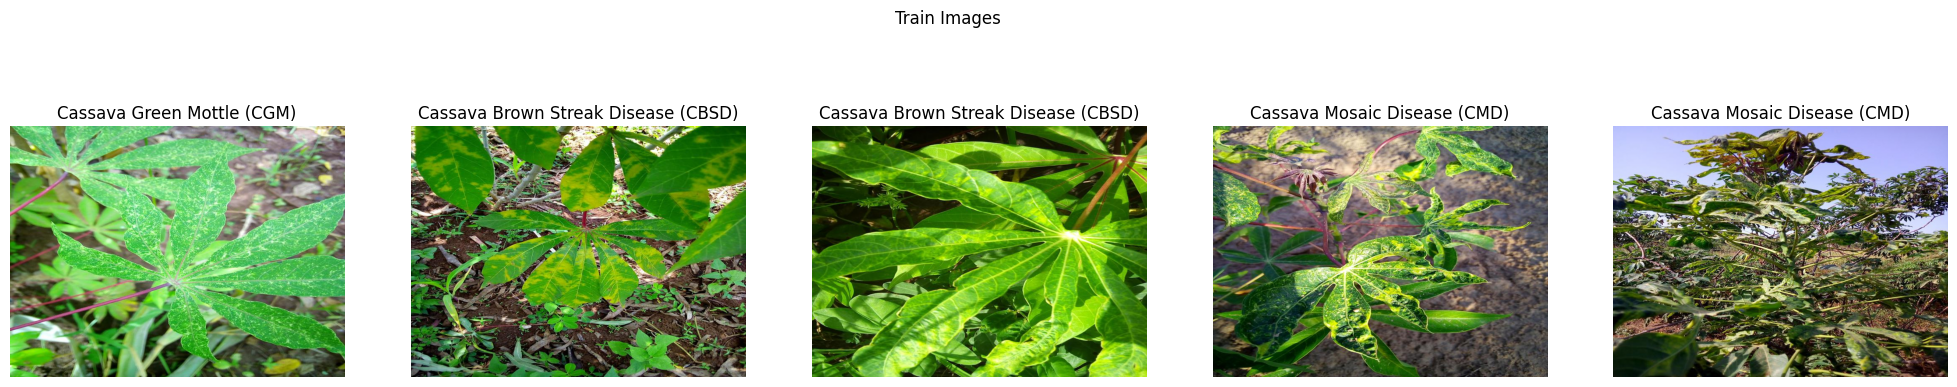

In [24]:
train_sample = train_df.sample(5)
display_images(train_sample['filename'].values, train_sample['label'].values, title="Train Images")

# Display some test images

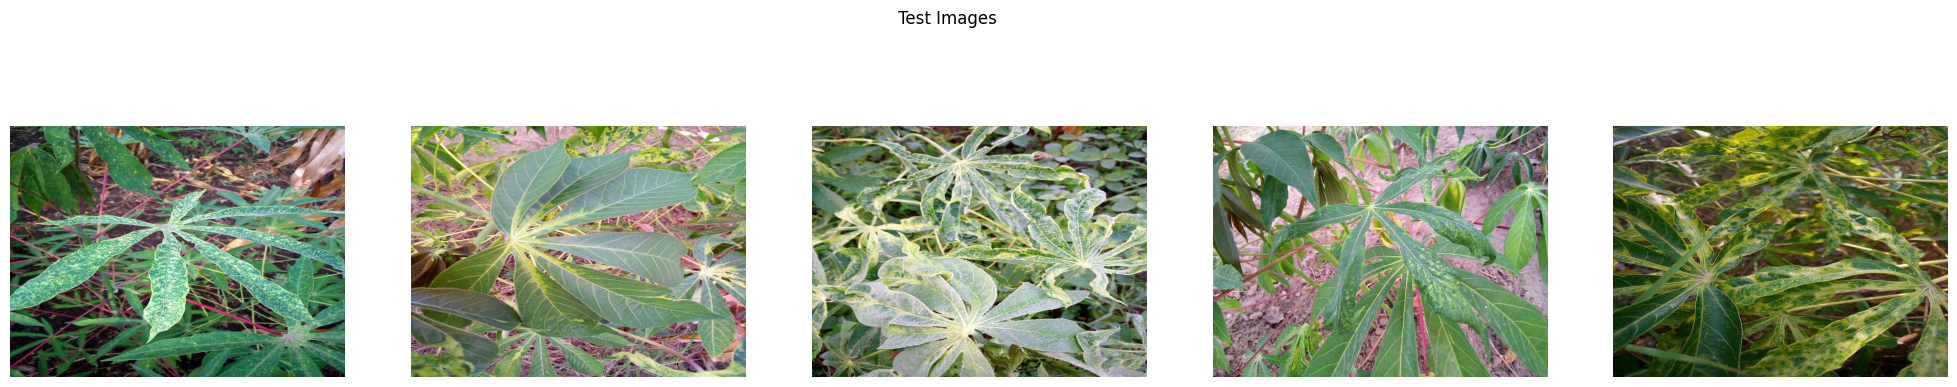

In [25]:
test_sample = test_df.sample(5)
display_images(test_sample['filename'].values, title="Test Images")

# Count the occurrences of each class

In [26]:
class_counts = train_df['label'].value_counts()

# Print class counts

In [27]:
print("Class Counts:\n", class_counts)

Class Counts:
 label
Cassava Mosaic Disease (CMD)           10526
Healthy                                 2061
Cassava Green Mottle (CGM)              1909
Cassava Brown Streak Disease (CBSD)     1751
Cassava Bacterial Blight (CBB)           870
Name: count, dtype: int64


# Bar Graph

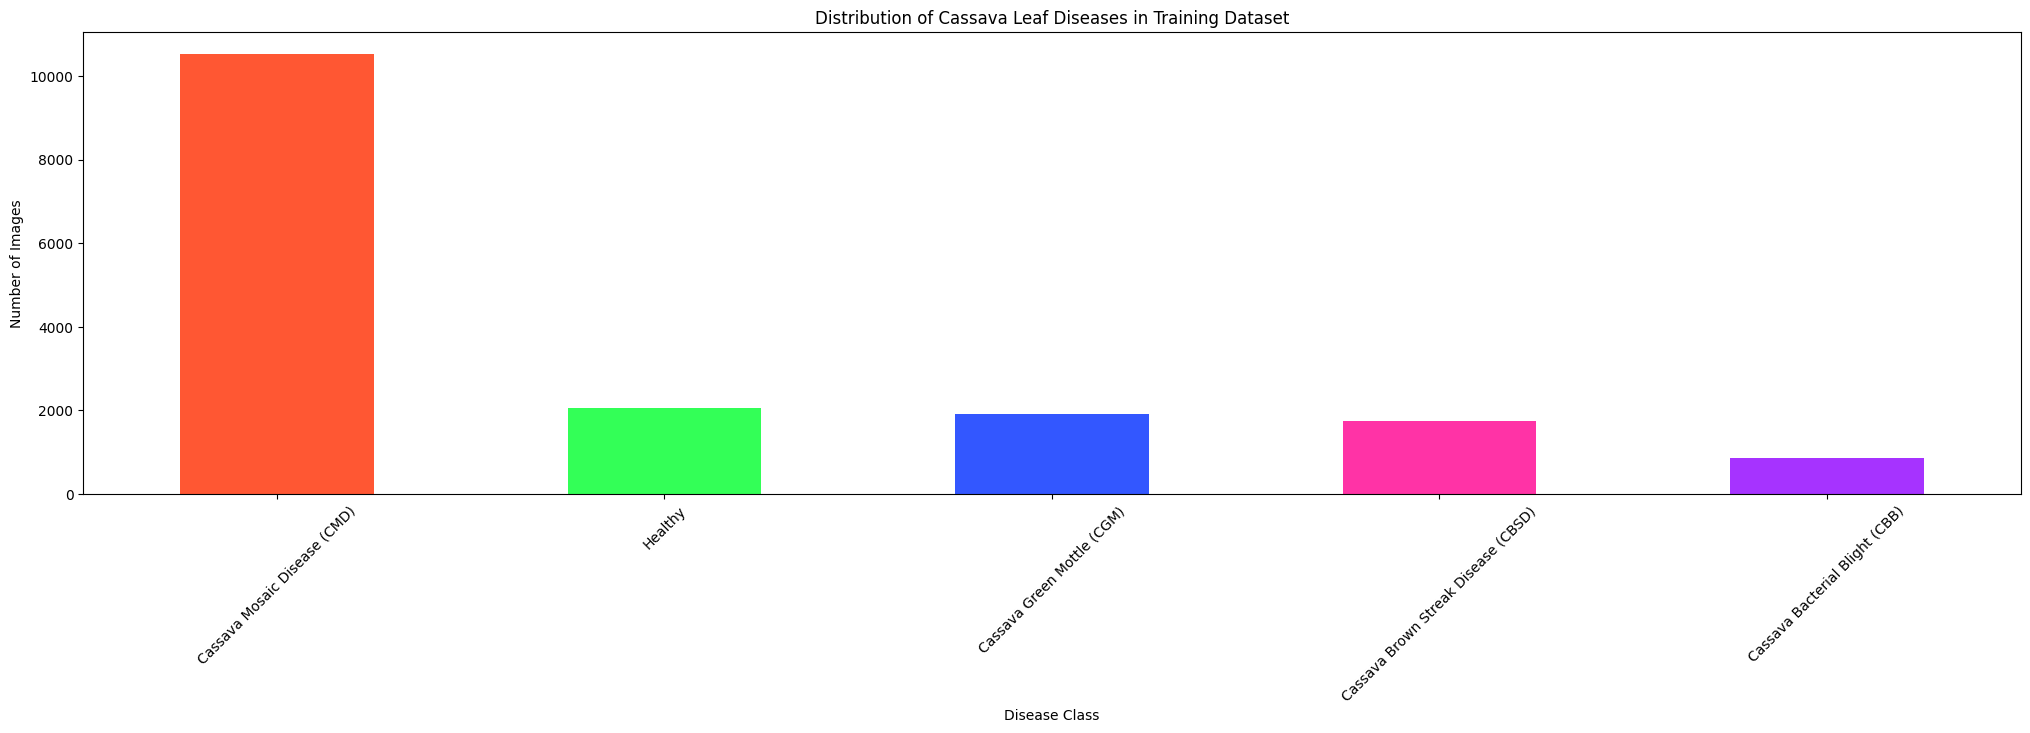

In [28]:
colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A6', '#A633FF']

plt.figure(figsize=(25, 6))
class_counts.plot(kind='bar', color=colors)
plt.title('Distribution of Cassava Leaf Diseases in Training Dataset')
plt.xlabel('Disease Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


# Pie Chart

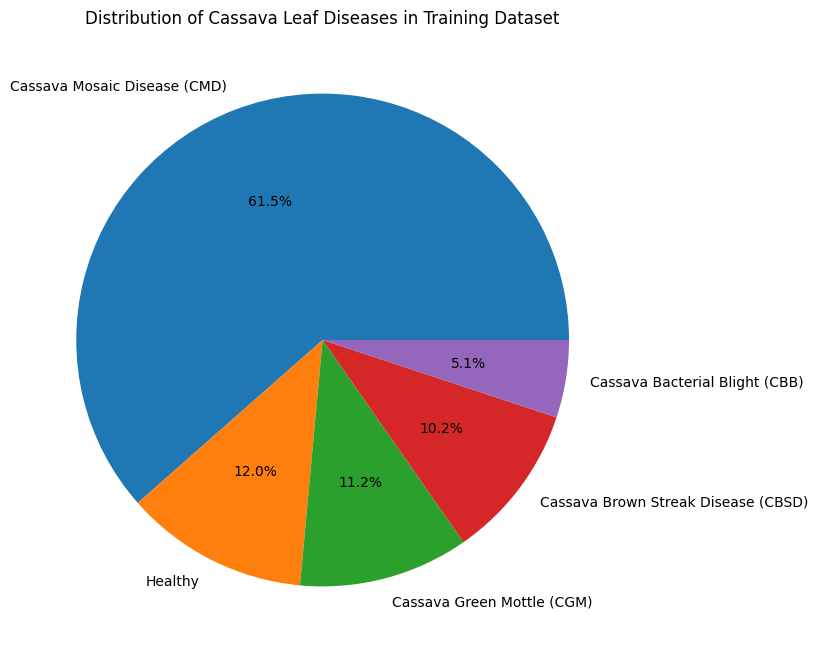

In [29]:
plt.figure(figsize=(8, 8))
class_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Cassava Leaf Diseases in Training Dataset')
plt.ylabel('')
plt.show()

# Save the predictions to a CSV file for submission

In [30]:
test_df[['filename', 'prediction']].to_csv('submission.csv', index=False)